In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.utils.data as data

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model Defination
Creating a simple prediction model that has one hidden layer and using tanh as activation function

In [3]:
class SimpleClassifier(nn.Module):

    def __init__(self,num_inputs,num_hidden,num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs,num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden,num_outputs)

    def forward(self,X):
        X = self.linear1(X)
        X = self.act_fn(X)
        X = self.linear2(X)
        return X

In [4]:
model = SimpleClassifier(num_inputs=2,num_hidden=4,num_outputs=1)

### defining loss function and optimiser

In [5]:
loss_module = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Creating Dataset 

In [6]:
class XORDataset(data.Dataset):

    def __init__(self,size,std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate()

    def generate(self):
        data  = torch.randint(low=0, high=2, size=(self.size,2), dtype=torch.float32)
        label = ((data.sum(dim=1)) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self,idx):
        return self.data[idx], self.label[idx]
        

In [7]:
train_dataset = XORDataset(size=2500)
data_loader = data.DataLoader(train_dataset,batch_size=124,shuffle=True)

# Visualising Dataset

In [8]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

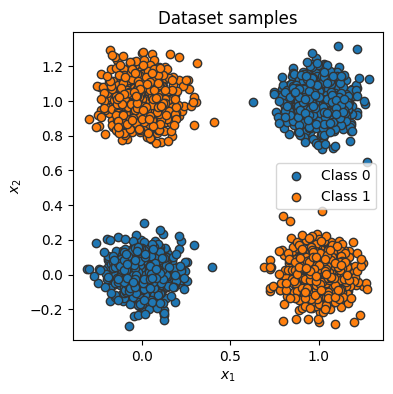

In [9]:
visualize_samples(train_dataset.data,train_dataset.label)

# Training the model

In [10]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [11]:
def train_model(model,optimizer,data_loader,loss_module,num_epochs=100):
  model.train()

  for epoch in range(num_epochs):
    for data_inputs, data_labels in data_loader:
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)

        loss = loss_module(preds,data_labels.float())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

In [12]:
train_model(model, optimizer, data_loader, loss_module)

# Testing the model

In [13]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [14]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [15]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


# Visualising model classification

In [16]:
from matplotlib.colors import to_rgba

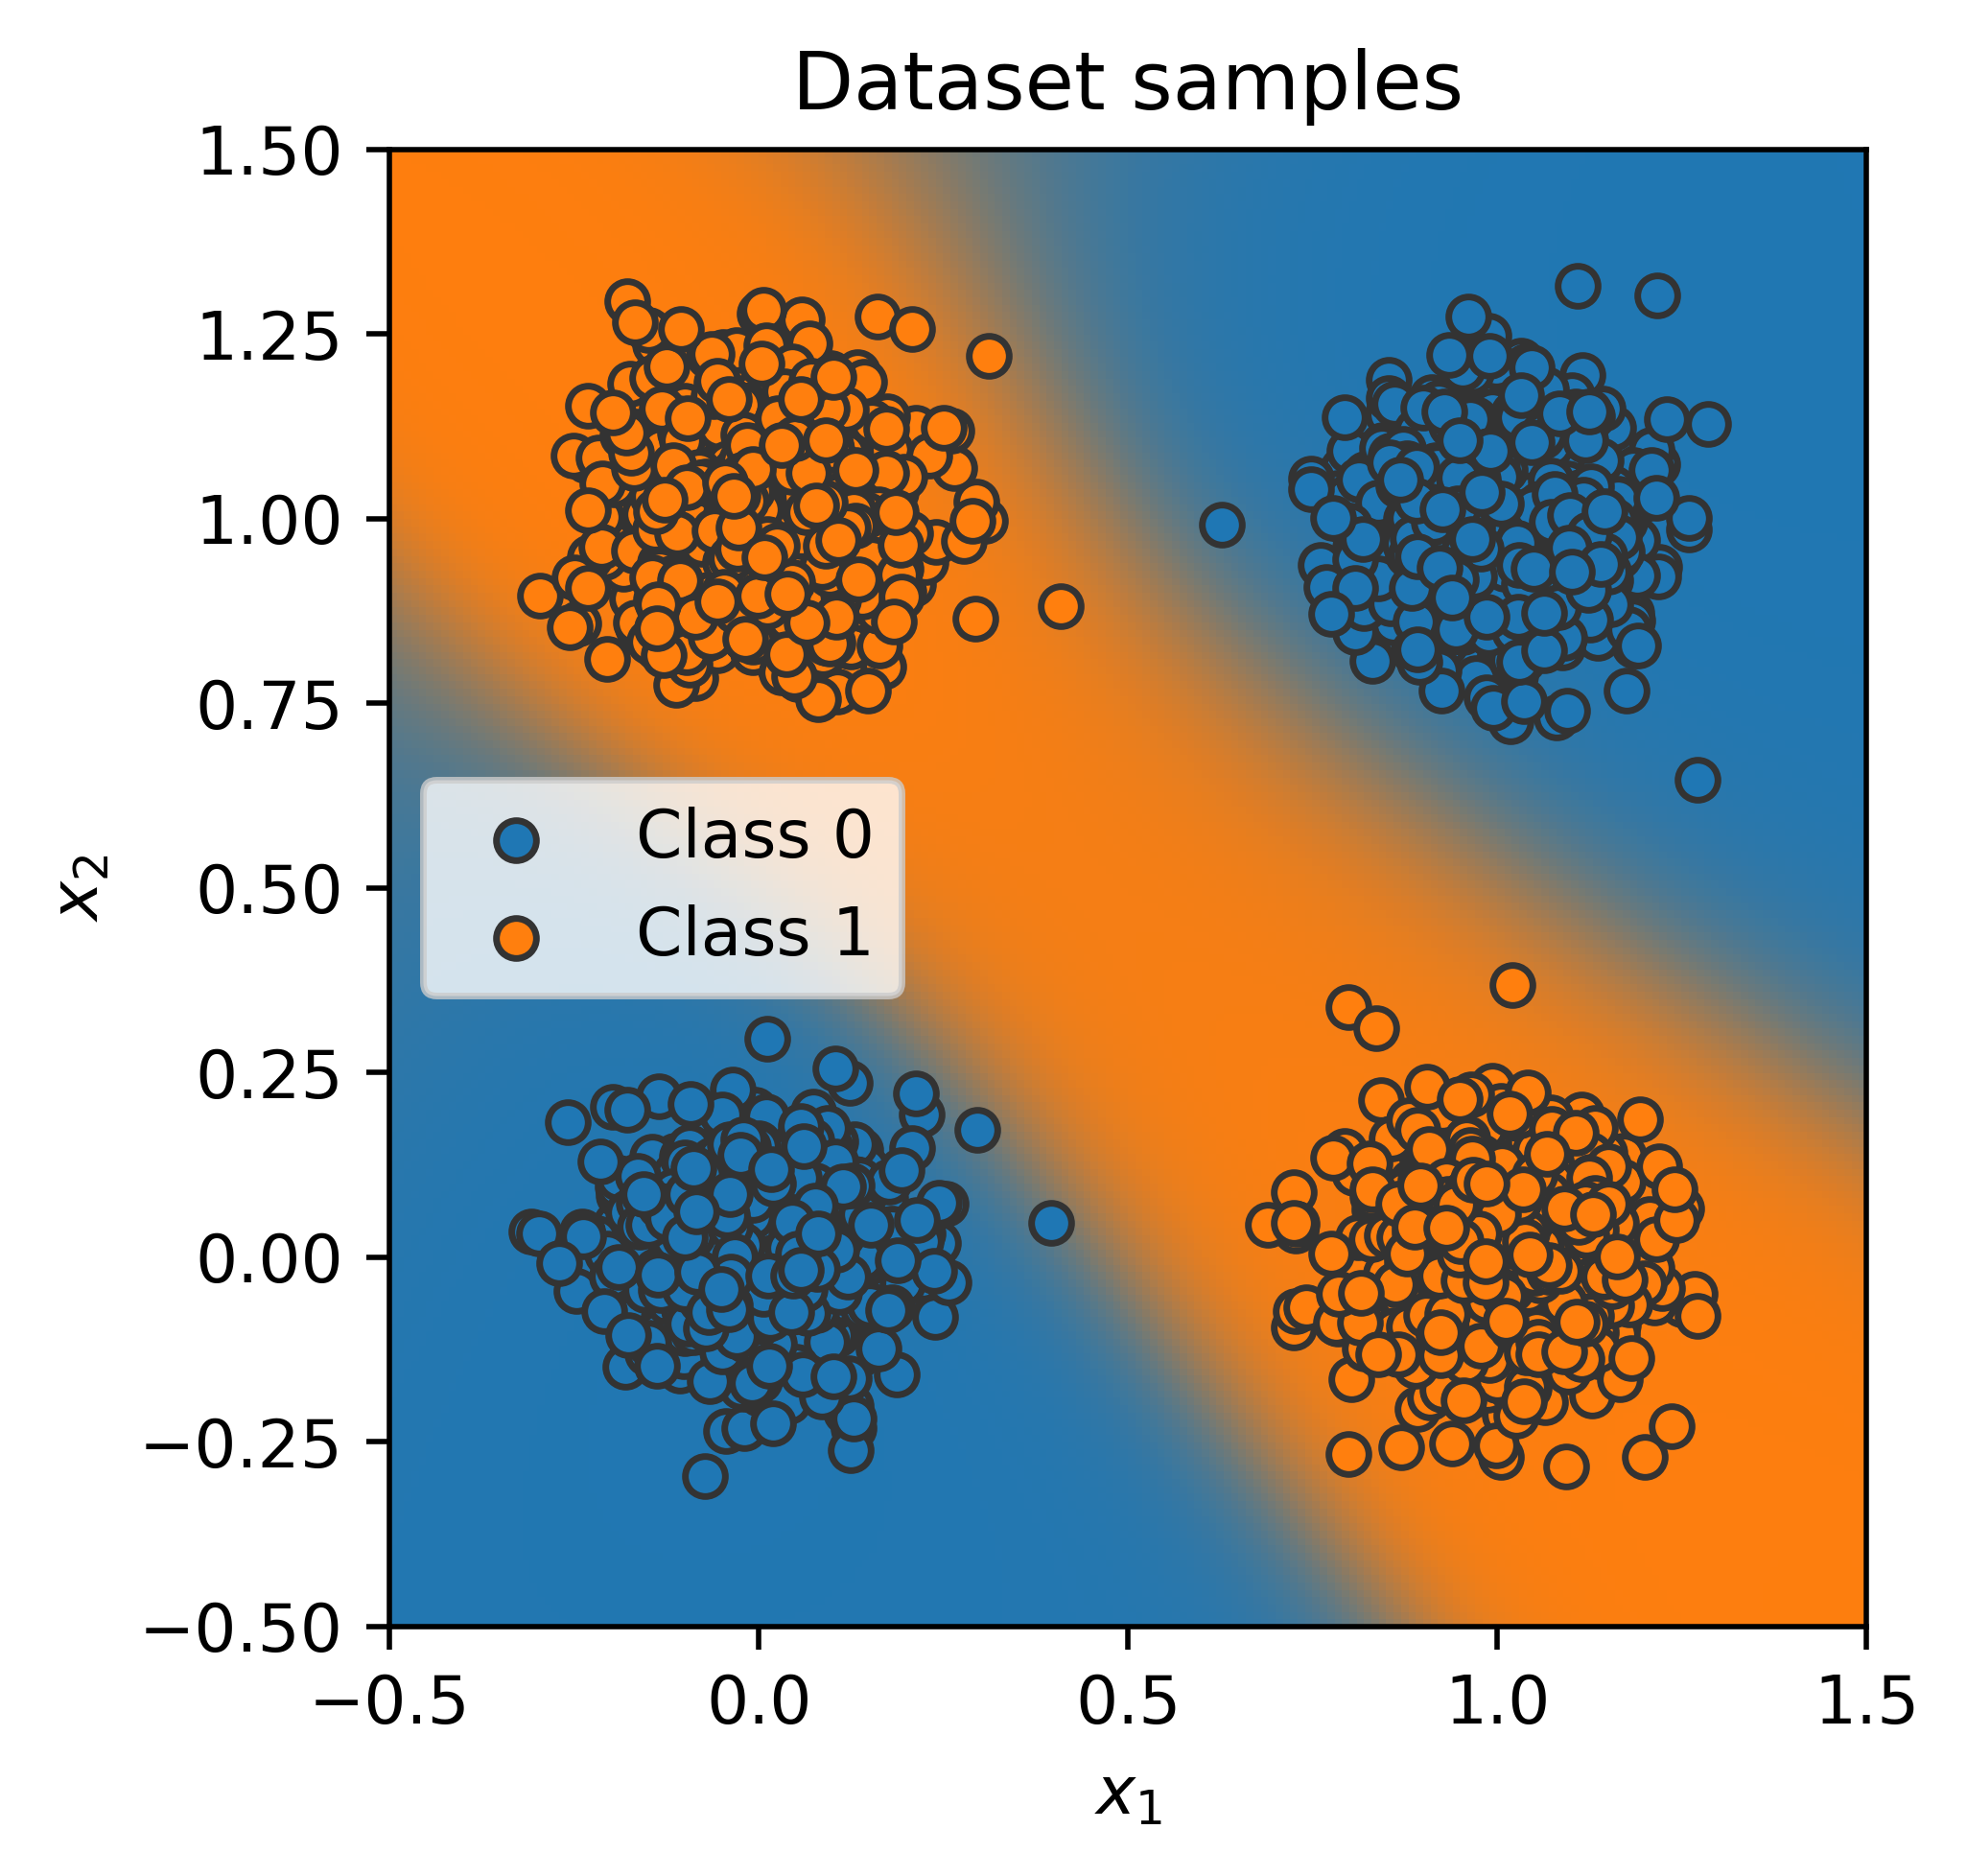

In [17]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, train_dataset.data, train_dataset.label)
plt.show()

# Saving the model

In [18]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.1400,  0.4972],
        [ 2.5142,  2.0526],
        [-2.9277, -3.3314],
        [ 1.4999, -1.9249]])), ('linear1.bias', tensor([-0.2704, -3.4246,  1.5172, -1.0561])), ('linear2.weight', tensor([[ 1.4329, -4.3537, -4.7507,  2.3929]])), ('linear2.bias', tensor([-2.0860]))])
